In [3]:
import random 
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [5]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## transposed convolution exam

In [6]:
input = torch.tensor([[[[1., 1.], [2., 2.]]]])
print("input data")
print(input)
print("===========")

print("ordinal Convolution")
m = nn.Conv2d(1, 1, 2, stride = 1, bias = False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("kernel")
print(m.weight)
print("output")
print(m(input))

print("=============")
print("転置畳み込み")
m = nn.ConvTranspose2d(1, 1, 2, stride = 1, bias = False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("kernel")
print(m.weight)
print("output")
print(m(input))

input data
tensor([[[[1., 1.],
          [2., 2.]]]])
ordinal Convolution
kernel
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
output
tensor([[[[17.]]]], grad_fn=<MkldnnConvolutionBackward>)
転置畳み込み
kernel
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
output
tensor([[[[ 1.,  3.,  2.],
          [ 5., 13.,  8.],
          [ 6., 14.,  8.]]]], grad_fn=<ThnnConvTranspose2DBackward>)


## Generator の実装

In [17]:
class Generator(nn.Module):
    
    def __init__(self, z_dim = 20, image_size = 64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8, 
            kernel_size = 4, stride = 1), 
            nn.BatchNorm2d(image_size * 8), 
            nn.ReLU(inplace = True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size*4, 
                                kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(image_size * 4), 
            nn.ReLU(inplace = True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2, 
                                kernel_size = 4, stride = 2, padding = 1), 
            nn.BatchNorm2d(image_size * 2), 
            nn.ReLU(inplace = True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size, 
                                kernel_size = 4, stride = 2, padding = 1), 
            nn.BatchNorm2d(image_size), 
            nn.ReLU(inplace = True)
        )

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size = 4, 
                                stride = 2, padding = 1), 
            nn.Tanh()
        )

        # 白黒なので、出力チャンネルは1つだけ

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out
        


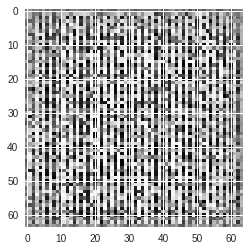

In [18]:
# 動作確認
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
%matplotlib inline

G = Generator(z_dim = 20, image_size = 64) # z_dim は入力する乱数の次元。決め方は適当

input_z = torch.randn(1, 20)
# tensorサイズを(1, 20, 1, 1)に変更
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 偽画像を生成
fake_images = G(input_z)

image_transformed = fake_images[0][0].detach().numpy()  # detachで勾配情報を消す
plt.imshow(image_transformed, "gray")
plt.show()


In [29]:
fake_images[0][0]

tensor([[-0.0826,  0.1698, -0.0591,  ..., -0.0986, -0.0329,  0.0289],
        [ 0.2607,  0.3450, -0.1316,  ...,  0.0338, -0.0868,  0.2567],
        [ 0.3083,  0.4052, -0.2010,  ...,  0.2688, -0.1401,  0.0752],
        ...,
        [ 0.0826, -0.0356,  0.0411,  ...,  0.5008,  0.4175,  0.1657],
        [ 0.1151,  0.4627, -0.4769,  ...,  0.6850, -0.5846,  0.2898],
        [ 0.1020, -0.0548,  0.1507,  ..., -0.0889,  0.0643,  0.0715]],
       grad_fn=<SelectBackward>)

In [27]:
fake_images[0][0].detach().numpy().shape

(64, 64)

## Discriminatorの実装

In [30]:
class Discriminator(nn.Module):

    def __init__(self, z_dim = 20, image_size = 64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size = 4, 
                    stride=2, padding = 1), 
            nn.LeakyReLU(0.1, inplace = True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size * 2, kernel_size = 4, 
                    stride = 2, padding = 1), 
            nn.LeakyReLU(0.1, inplace = True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size * 2, image_size * 4, kernel_size=4, 
                    stride = 2, padding = 1), 
            nn.LeakyReLU(0.1, inplace = True)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size * 4, image_size * 8, kernel_size = 4, 
                        stride =2, padding = 1), 
            nn.LeakyReLU(0.1, inplace = True)
        )

        self.last = nn.Conv2d(image_size * 8, 1, kernel_size = 4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out


In [31]:
# 動作確認

D = Discriminator(z_dim = 20, image_size =64)

# 偽画像の生成
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 偽画像を識別器に入力
d_out = D(fake_images)

# 出力d_outにSigmoidをかけて0~1に変換
print(nn.Sigmoid()(d_out))

tensor([[[[0.5031]]]], grad_fn=<SigmoidBackward>)


In [38]:
torch.full((25, ), 1)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.])

In [40]:
nn.Sigmoid()(d_out).view(-1)

tensor([0.5031], grad_fn=<ViewBackward>)

In [54]:
def make_datapath_list():
    """
    学習・検証の画像データとアノテーションデータへのファイルパスリストを作成する
    """

    train_img_list = []     # 画像ファイルパスを格納

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx) + ".jpg"  # image_path
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx) + ".jpg"
        train_img_list.append(img_path)

    return train_img_list




In [42]:
class ImageTransform():
    """
    画像の前処理を行うクラスだよ
    """

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize(mean, std)
        ])

    def __call__(self, image):
        return self.data_transform(image)

        

In [52]:
class gan_img_dataset(data.Dataset):
    """
    画像のdatasetクラス。
    PyTorchのDatasetクラスを継承
    """

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)   # return the number of images

    def __getitem__(self, index):
        """
        前処理をした画像のTensor形式のデータを取得するよ　
        """

        img_path = self.file_list[index]
        img = Image.open(img_path)    # [hieght][width][black and white]

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed
    


## DataLoaderの作成と動作確認

In [50]:
import os
os.getcwd()
#os.chdir("5_gan_generation")

'/home/statistics3/pytorch_advanced/5_gan_generation'

In [55]:
# make file list
train_img_list = make_datapath_list()

# Datasetを作成
mean = (0.5, )
std = (0.5, )
train_dataset = gan_img_dataset(
    file_list = train_img_list, transform = ImageTransform(mean, std)
)

# make dataloader 
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)

# 動作の確認
batch_iterator = iter(train_dataloader)     # convert iterator
images = next(batch_iterator) # 一番目の要素を取り出す
print(images.size())


torch.Size([64, 1, 64, 64])


# 学習させるよ

In [57]:
# initilize network

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        # Conv2d and ConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

    elif classname.find("BatchNorm") != -1:
        # BatchNorm2dの初期化

        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("complete initilization of Network")

complete initilization of Network


In [75]:
# train modelを作成

def train_model(G, D, dataloader, num_epochs):

    # can I use GPU ?
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス:", device)

    # 最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004   # g_lr, d_lrはそれぞれgenerator, discriminatorの学習率
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 誤差関数の定義
    # BCE は Binarry Cross Entropy の略 WithLogitsでlogistic functionを噛ませるという意味
    criterion = nn.BCEWithLogitsLoss(reduction = "mean")

    # parameter を　ハードコーディング
    z_dim = 20
    mini_batch_size = 64

    # network to GPU!!!
    G.to(device)
    D.to(device)

    G.train()   # make model training mode
    D.train()   # make model training mode

    # networkがある程度固定できれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # set the iteration counter 
    iteration = 1
    logs = []

    # epoch
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0     # epochの損失和
        epoch_d_loss = 0.0

        print("=========================")
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print("=========================")
        print("(train)")

        for images in dataloader:
            """
            Discriminatorの学習
            mini batch size = 1 だと, batch normilization errorが出るので避ける
            """

            if images.size()[0] == 1:
                continue
            images = images.to(device)

            # 正解ラベルと偽ラベルを作成
            mini_batch_size = images.size()[0]
            label_real = torch.full((mini_batch_size, ), 1).to(device) # 正解データのラベル付
            label_fake = torch.full((mini_batch_size, ), 0).to(device) # 不正解のラベル付

            # 真の画像かどうかを判定
            d_out_real = D(images)

            # fake images を作成して判定させる
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # Discriminatorの誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # back-propagation
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # =================================================
            # 2. Generator training 
            # =================================================

            # ニセの画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # back-propagation
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # 値の記録
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epoch のphaseごとのloss and accuracy
        t_epoch_finish = time.time()
        print("===============")
        print("epoch {}  || epoch D loss:{:.4f}  || epoch G loss:{:.4f}".format(epoch+1, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print("timer: {:.4f} sec.".format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D


In [76]:
num_epochs = 200
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs = num_epochs
)

Epoch 81/200
(train)
epoch 81  || epoch D loss:0.0312  || epoch G loss:0.7125
timer: 0.3718 sec.
Epoch 82/200
(train)
epoch 82  || epoch D loss:0.0013  || epoch G loss:0.8217
timer: 0.3708 sec.
Epoch 83/200
(train)
epoch 83  || epoch D loss:0.0005  || epoch G loss:0.9339
timer: 0.3691 sec.
Epoch 84/200
(train)
epoch 84  || epoch D loss:0.0466  || epoch G loss:0.7328
timer: 0.3692 sec.
Epoch 85/200
(train)
epoch 85  || epoch D loss:0.0051  || epoch G loss:0.6473
timer: 0.3762 sec.
Epoch 86/200
(train)
epoch 86  || epoch D loss:0.0011  || epoch G loss:0.7836
timer: 0.3799 sec.
Epoch 87/200
(train)
epoch 87  || epoch D loss:0.0006  || epoch G loss:0.9388
timer: 0.3757 sec.
Epoch 88/200
(train)
epoch 88  || epoch D loss:0.0004  || epoch G loss:1.0378
timer: 0.3704 sec.
Epoch 89/200
(train)
epoch 89  || epoch D loss:0.0003  || epoch G loss:0.9746
timer: 0.3772 sec.
Epoch 90/200
(train)
epoch 90  || epoch D loss:0.0377  || epoch G loss:0.8454
timer: 0.3734 sec.
Epoch 91/200
(train)
epoch 91 

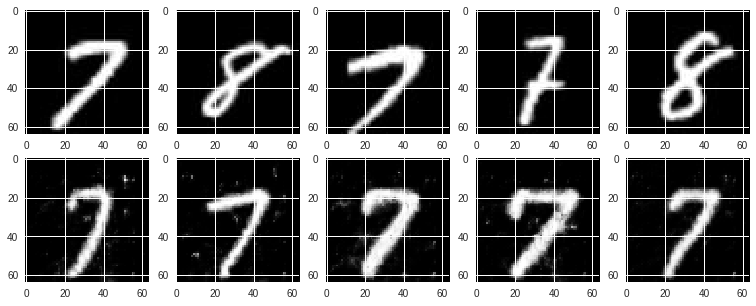

In [79]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数発生
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)   # convert to iterator
images = next(batch_iterator)  # extract 1st element

# out put!!
figure = plt.figure(figsize = (13, 5))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), "gray")

    # 下の段に生成データ
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), "gray")